# COGS 108 - Final Project 

# Overview

In order to see whether or not there is a significant correlation between the weather and the number of rides made per day in New York, appropriate data has been gathered and analyzed. The weather is divided into three different attributes; temperature, wind speed, and humidity, for each hour during the day in May of 2014. These three attributes were analyzed against the number of Uber rides made in each month, to see if we can visually see the correlation between these three attributes and the rides made.

# Names

- Zijian Liu
- Pin-Hsuan Chen
- Kyle Reed 
- Yunji Ryu
- Jing Wei

# Group Members IDs

- A15723355
- A14012598
- A11839833
- A15729483
- A14767336

# Research Question

Research question: How does the weather condition, specifically wind speed, temperature, humidity, and hourly weather description, affect the overall number of rides during the day in NYC?


## Background and Prior Work

There were no prior work done for our topic. But based on our experiences with acquiring rides in certain weather conditions, there are numerous reasons why one can consider getting a taxi/Uber compared to getting there by foot or other means. One of the main components that influences this decision is weather. Engineers in the New York State created a system to provide information about the road conditions in New York State, specifically catering towards the more haphazard winter season, providing whether the highway will be blocked or not due to snow and ice operations. They also included a report for each of the observed years to include a more detailed description of the road conditions and list how accurate their report was. But not much of these affected the road conditions during the non-winter seasons. Whether it's the wind travel advisory warnings, slippery driveways on a rainy day, drivers and the riders tend to be more wary of the environmental situations around the road regardless of the season, which affects their decision to get a ride or not, conclusively affecting the number of rides that are made in New York. In order to investigate this information, we decided to use our readily available public data to analyze and infer to the possible correlations listed in our research question and hypothesis.

References (include links):
- 1) https://www.dot.ny.gov/wta (New York State Winter Travel Advisory System for 2014 - 2015 winter season)
- 2) https://www.dot.ny.gov/divisions/engineering/technical-services/highway-data-services/traffic-data (Traffic Data Report based on various regions in New York State in 2014)

# Hypothesis


1. Temperature will have an effect on ride count.
2. Wind speed will have an effect on ride count.
3. Humidity will have an effect on ride count.
4. Weather description will have an effect on ride count. 

We predict that these factor will correlate to the number of rides in some way. It is harder to say whether it will be a negative or positive correlation because unfavorable weather conditions can include either extremely low temperatures or extremely high temperatures. However, we predict ride counts to be higher on days with unfavorable weather conditions, such as thunderstorm or rain. For instance, if for a particular hour, the wind speed, humidity, and temperature are all relatively higher compared to the whole dataset, we predict the ride count to be higher as well.

We believe that unfavorable weather conditions will lead to higher ride counts because people are less willing to walk or take public transportation in those conidtions. For example, if the weather was nice and sunny, people are more willing to save money and walk a couple of blocks. However, if it was rainy and cold, there is a higher chance of people getting a ride so that they can stay dry and warm. 

# Dataset(s)

- Dataset Name: Historical Hourly Weather Data 2012-2017
- Link to the dataset: https://www.kaggle.com/selfishgene/historical-hourly-weather-data
- Number of observations: 45253
- Description: This dataset includes hourly weather data for 30 US cities and others, from 2012 to 2017. Each attributes of the weather is divided into separate data sources on the website; acquired from Weather API and sorted by Kaggle user 'Selfish Gene'. For the purpose of this project, we decided to focus on these four weather attributes: humidity, temperature, wind speed, and weather description. These four attributes were chosen because how hot or cool it "feels" outside is a result of a combination of these factors. 
    - Humidity: We will extract hourly humidity data for New York from this dataset.
    - Temperature: We will extract hourly temperature data for New York from this dataset. We noticed that the temperatures are listed as Kelvin, we will convert this to fahrenheit so the results are easier to interpret.
    - Wind Speed: We will extract hourly wind speed data for New York from this dataset.
    - Weather: We will extract hourly weather description data for New York from this dataset.


- Dataset Name: Historical Uber Rides Data May 2014
- Link to the dataset: https://github.com/fivethirtyeight/uber-tlc-foil-response
- Number of observations: 652435
- description: This data includes the Uber rides in New York City in May 2014, but the raw data is base on the time, latitude and longitude of each time people use Uber. We analyzed the raw data and counted the use of Uber by hour.

# Setup

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import datetime
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import patsy
import statsmodels.api as sm

from scipy.stats import pearsonr, norm, ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Data cleaning

Describe your data cleaning steps here.

The first dataset we are going to clean is the ride data. The raw ride data contains every instance of a ride, along with a timestamp of when it took place. However, this format is incompatible with the rest of our data, which are formatted with one instance per hour. What we need is to compress this dataset from individual counts to a number of counts per hour.

This is not only conducive to our analysis, but also helps depersonalize the data for data privacy purposes. Each individual instance of a ride is already depersonalized, since it contains no personally identifiable information about the riders or drivers of the Uber ride, but compressing the data into hourly counts makes it even less identifiable, since not even the individual rides are distinguishable anymore.

The steps we used to achieve this are as follows

1. Load and read all the CSV file. We will also take a look at what the dataset looks like and how many enteries there are. Here we noticed that we need to condense our dataset in some way to match the hourly weather descriptions. 
2. Initialize a dictionary for each hour in May 2014, the month we are analyzing. This will serve as a backbone to scrape the counts from the raw data.
3. Run through the raw data, and for each ride in the dataset add 1 to the count of rides during that respective hour in the dict
4. Once the ride counts have been collected, save the dictionary as a csv file for later use.

[Steps 2-4 are commented out here since re-running them takes a long time, and since we already have the .csv file we don't need to re-run it anyway]

In [3]:
# Step 1 
pickup_df = pd.read_csv('uber-raw-data-may14.csv')
pickup_df.head()
print(pickup_df.shape)

(652435, 4)


In [4]:
'''
#Step 2
counts = {}
for date in np.arange(1,32):
    for time in np.arange(0,24):
        counts["5/{}/2014 {}".format(date,time)] = 0
        
#Step 3
for index, row in pickup_df.iterrows():
        counts[row[0][:row[0].index(":")]] += 1

#Step 4
with open('uber_hourly_counts_may.csv', 'w') as f:
    for key in counts.keys():
        f.write("%s,%s\n"%(key,counts[key]))
'''

'\n#Step 2\ncounts = {}\nfor date in np.arange(1,32):\n    for time in np.arange(0,24):\n        counts["5/{}/2014 {}".format(date,time)] = 0\n        \n#Step 3\nfor index, row in pickup_df.iterrows():\n        counts[row[0][:row[0].index(":")]] += 1\n\n#Step 4\nwith open(\'uber_hourly_counts_may.csv\', \'w\') as f:\n    for key in counts.keys():\n        f.write("%s,%s\n"%(key,counts[key]))\n'

The next four datasets we are going to clean are for weather attributes, namely: weather description, temperature, wind speed, and humidity. After looking over the datasets and doing some calculations, we are certain that each dataset should have 744 observations along with two columns (one for datetime and one for attribute). 

Since we are only interested in weather data for New York in May, we will drop all the data for other cities and other months/year. 

The steps included to clean the weather description dataset are as follows:
1. Load the CSV file. 
2. Keep only the datasets that are for New York in May.

In [5]:
# Step 1 
weather_description_df = pd.read_csv('weather_description.csv')

#Step 2 
weather_description_df = weather_description_df[['datetime','New York']]
weather_description_df = weather_description_df[weather_description_df['datetime'].astype(str).str.contains('2014-05')]

# Print to make sure we have 744 enteries and two columns after cleaning 
print(weather_description_df.shape)

#checking if there are null values 
print(sum(weather_description_df['New York'].isnull()))

# Calling count() on the column containing New York data to see the specific content for weather description
description_item = weather_description_df.groupby(["New York"]).count()
print(description_item)


(744, 2)
0
                              datetime
New York                              
broken clouds                      106
few clouds                          43
fog                                 11
haze                                24
heavy intensity drizzle              1
heavy intensity rain                27
light intensity drizzle             10
light rain                         149
mist                               104
moderate rain                       19
overcast clouds                     61
scattered clouds                    65
sky is clear                       120
thunderstorm                         2
thunderstorm with heavy rain         1
very heavy rain                      1


The steps included to clean the temperature dataset are as follows:
1. Load the CSV file. 
2. Keep only the datasets that are for New York in May. 
3. Convert enteries in temperature from Kelvin to fahrenheit so its easier to interpret result. 


In [6]:
#Step 1 
temperature_df = pd.read_csv('temperature.csv')

#Step 2 
temperature_df = temperature_df[temperature_df['datetime'].astype(str).str.contains('2014-05')]
temperature_df = temperature_df[['datetime','New York']]

# Print to make sure we have 744 enteries and two columns after cleaning. 
print(temperature_df.shape)

#checking if there are null values 
print(sum(temperature_df['New York'].isnull()))

#Step 3
for i in temperature_df.index.values:
    k_temp = temperature_df.loc[i,'New York']
    f_temp = 9/5*(k_temp-273.15)+32
    f_temp_2 = int(str(f_temp)[:2])
    temperature_df.loc[i,'New York'] = f_temp_2

temperature_df.head()

(744, 2)
0


,datetime,New York
13836,2014-05-01 00:00:00,51.0
13837,2014-05-01 01:00:00,52.0
13838,2014-05-01 02:00:00,52.0
13839,2014-05-01 03:00:00,54.0
13840,2014-05-01 04:00:00,53.0


The steps included to clean the wind speed dataset are as follows:
1. Load the CSV file. 
2. Keep only the datasets that are for New York in May.

In [7]:
#Step 1
wind_speed_df = pd.read_csv('wind_speed.csv')

#Step 2 
wind_speed_df = wind_speed_df[['datetime','New York']]
wind_speed_df = wind_speed_df[wind_speed_df['datetime'].astype(str).str.contains('2014-05')]
# Print to make sure we have 744 enteries and two columns after cleaning. 
print(wind_speed_df.shape)

#checking if there are null values 
print(sum(wind_speed_df['New York'].isnull()))

wind_speed_df.head()

(744, 2)
0


,datetime,New York
13836,2014-05-01 00:00:00,4.0
13837,2014-05-01 01:00:00,5.0
13838,2014-05-01 02:00:00,5.0
13839,2014-05-01 03:00:00,5.0
13840,2014-05-01 04:00:00,4.0


The steps included to clean the humidity dataset are as follows:
1. Load the CSV file. 
2. Keep only the datasets that are for New York in May.

We notice here that there are two NaN values in our dataset. At this point of data cleaning, we cannot just drop the NaN values because we are not yet at our final goal, which is to combine ride count data with weather data using our hourly time stamps. If we were to drop the NaN values now, when we do combine the individual dataframes, the indices of our hourly time stamps won't match up. For this reason, we've decided to change that value to -1 for now and eventually drop the NaN values when we combine everything. 

In [8]:
# Step 1 
humidity_df = pd.read_csv('humidity.csv')

#Step 2 
humidity_df = humidity_df[['datetime','New York']]
humidity_df = humidity_df[humidity_df['datetime'].astype(str).str.contains('2014-05')]

# Print to make sure we have 744 enteries and two columns after cleaning. 
print(humidity_df.shape)

#checking if there is null values 
print(sum(humidity_df['New York'].isnull()))

#replacing null with -1 
humidity_df['New York'] = humidity_df['New York'].replace(np.NaN, -1)

humidity_df.head()



(744, 2)
2


,datetime,New York
13836,2014-05-01 00:00:00,95.0
13837,2014-05-01 01:00:00,94.0
13838,2014-05-01 02:00:00,95.0
13839,2014-05-01 03:00:00,94.0
13840,2014-05-01 04:00:00,94.0


Now that we've cleaned all our datasets, we can put all the datasets into one dataframe. To do this we need to perfrom the following steps:
1. Rename all the columns so that it correctly matches with the types of data stored. 
2. Reset the index for each dataframe so that we can join them together successfully. 
3. Join everything into one dataframe and make sure the resulting dataframe is what we would expect.


In [9]:
# Step 1
weather_description_df.rename(columns={'New York':'description'}, inplace=True)
temperature_df.rename(columns={'New York':'temperature'}, inplace=True)
wind_speed_df.rename(columns={'New York':'wind speed'}, inplace=True)
humidity_df.rename(columns={'New York':'humidity'}, inplace=True)


# Step 2
weather_description_df = weather_description_df.reset_index(drop=True)
temperature_df = temperature_df.reset_index(drop=True)
wind_speed_df = wind_speed_df.reset_index(drop=True)
humidity_df = humidity_df.reset_index(drop=True)

#Step 3 
weather_description_df = weather_description_df.join(temperature_df['temperature'])
weather_description_df = weather_description_df.join(wind_speed_df['wind speed'])
weather_description_df = weather_description_df.join(humidity_df['humidity'])


# Take a look. 
weather_description_df.head()



,datetime,description,temperature,wind speed,humidity
0,2014-05-01 00:00:00,moderate rain,51.0,4.0,95.0
1,2014-05-01 01:00:00,moderate rain,52.0,5.0,94.0
2,2014-05-01 02:00:00,moderate rain,52.0,5.0,95.0
3,2014-05-01 03:00:00,heavy intensity rain,54.0,5.0,94.0
4,2014-05-01 04:00:00,heavy intensity rain,53.0,4.0,94.0


Now that we have our weather data in a single dataframe as shown above, we can combine this with the ride count data. As mentioned earlier, we've compressed the ride data into hourly ride counts, and this is stored in a separate CSV file called 'uber_hourly_counts_may.csv'.

Similar to how we cleaned and combined the weather data, we will need to perform the following steps to the ride count CSV file:

1. Load the CSV file. 
2. Make sure there are 744 enteries and take a look at the data.  
3. Rename is column to reflect the data stored and reindex to match other datasets.



In [10]:
# Step 1
ride_count_df = pd.read_csv('uber_hourly_counts_may.csv')

# Step 2 
print(ride_count_df.shape)
print(ride_count_df.head())

# Step 3
ride_count_df.rename(columns={'Count':'Count'}, inplace=True)
weather_description_df = weather_description_df.join(ride_count_df['Count'])


(744, 2)
         Hour  Count
0  5/1/2014 0    348
1  5/1/2014 1    179
2  5/1/2014 2    101
3  5/1/2014 3    172
4  5/1/2014 4    241


Now we can rename this newly combined dataframe 'df' and make sure that it is what we expect. 


In [11]:
df = weather_description_df
df.head()

,datetime,description,temperature,wind speed,humidity,Count
0,2014-05-01 00:00:00,moderate rain,51.0,4.0,95.0,348
1,2014-05-01 01:00:00,moderate rain,52.0,5.0,94.0,179
2,2014-05-01 02:00:00,moderate rain,52.0,5.0,95.0,101
3,2014-05-01 03:00:00,heavy intensity rain,54.0,5.0,94.0,172
4,2014-05-01 04:00:00,heavy intensity rain,53.0,4.0,94.0,241


Now that we have achieved our final goal in data cleaning, we can go ahead and drop the NaN values in the humidity dataset earlier without messing up our indexing. Our decision to drop the NaN values is justified by the numerous other observations we have, meaning these two rows of data will not affect our analysis. 


In [12]:
# We need to change the -1 back to NaN and drop it from df
df['humidity'] = df['humidity'].replace(-1, np.NaN)
df = df.dropna()
print(df.shape)

(742, 6)


# Data Analysis & Results

In [13]:
'''
cols_plot = ['description', 'temperature','wind speed', 'humidity']
axes = weather_description_df[cols_plot].plot(marker='.', alpha=0.1, linestyle='None', figsize=(11, 9), subplots=True)
for y_axis in axes:
    y_axis.set_ylabel('counts')
'''

"\ncols_plot = ['description', 'temperature','wind speed', 'humidity']\naxes = weather_description_df[cols_plot].plot(marker='.', alpha=0.1, linestyle='None', figsize=(11, 9), subplots=True)\nfor y_axis in axes:\n    y_axis.set_ylabel('counts')\n"

Before we start our analysis, we can reorganize our dataframe. We are going to rename and reorder some columns so help with interpreting results. 

In [14]:
# Renaming and reordering columns 
df = df[['datetime','Count','description','temperature','wind speed','humidity']]
df['wind_speed'] = df['wind speed']
df['ride_count'] = df['Count']
df = df[['datetime','ride_count','description','temperature','wind_speed','humidity']]

We would also like to add a column to df called 'temp_diff' because both high and low temperature (colder or hotter weather) can have an effect on ride count, causing it to be a confounding variable in our analysis.

'temp_diff' is the difference in temperature between the entry and the average temperature. 

In [15]:
df['temp_diff'] = np.absolute(df['temperature'] - 61.8)
df.head()

,datetime,ride_count,description,temperature,wind_speed,humidity,temp_diff
0,2014-05-01 00:00:00,348,moderate rain,51.0,4.0,95.0,10.8
1,2014-05-01 01:00:00,179,moderate rain,52.0,5.0,94.0,9.8
2,2014-05-01 02:00:00,101,moderate rain,52.0,5.0,95.0,9.8
3,2014-05-01 03:00:00,172,heavy intensity rain,54.0,5.0,94.0,7.8
4,2014-05-01 04:00:00,241,heavy intensity rain,53.0,4.0,94.0,8.8


Before we start our analysis, we would like to see the correlations between our variables and descriptive statistics for our data.

In [16]:
print(df.describe())

        ride_count  temperature  wind_speed    humidity   temp_diff
count   742.000000   742.000000  742.000000  742.000000  742.000000
mean    876.000000    61.765499    2.141509   65.951482    6.192992
std     569.505316     7.855407    1.935583   22.689961    4.827391
min      52.000000    46.000000    0.000000   18.000000    0.200000
25%     396.500000    56.000000    1.000000   47.000000    2.200000
50%     787.500000    61.000000    2.000000   64.000000    5.200000
75%    1273.500000    66.000000    3.000000   91.000000    8.800000
max    3076.000000    86.000000   12.000000  100.000000   24.200000


In [17]:
print(df.corr())

             ride_count  temperature  wind_speed  humidity  temp_diff
ride_count     1.000000     0.197756   -0.009203  0.022967  -0.098279
temperature    0.197756     1.000000    0.170557 -0.401010   0.322311
wind_speed    -0.009203     0.170557    1.000000 -0.233347   0.174260
humidity       0.022967    -0.401010   -0.233347  1.000000  -0.354206
temp_diff     -0.098279     0.322311    0.174260 -0.354206   1.000000


Based on the correlation above, the ride count has a positive correlation with temperature and humidity, and negative correlation with wind speed and temp_diff. As the temperature and humidity increases over time, ride counts will likely increase. Ride counts will decrease over time as the the wind speed and the temperature difference increases over time.

# Data Visualization

Next, we are going to plot our datasets to visualize the relationship between different weather attributes and ride count. 

Text(0.5,0,'Temperature in Fahrenheit')

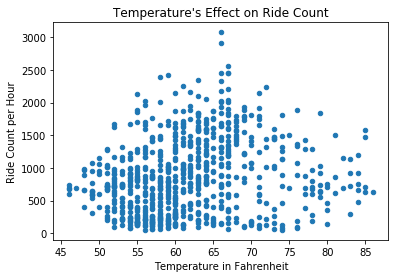

In [18]:
# Scatter Plot of Temperature and Ride Count
df.plot.scatter('temperature', 'ride_count')
# Can we include a prediction line? something like below?
#plt.plot([x / 1.0 for x in range(0, 25, 1)], df['temp_diff', c = 'Red'])
ax=plt.gca()
ax.set_title('Temperature\'s Effect on Ride Count')
ax.set_ylabel('Ride Count per Hour')
ax.set_xlabel('Temperature in Fahrenheit')

From the scatter plot above, the lower temperature range seems to be more concentrated on the range of ride counts within 0 to 2000 rides per hour. Which could suggest that the correlation between the temperature and the ride count exists, perhaps due to the fact that people are less likely to get to their destination by feet/other means in colder weather.

Text(0.5,0,'Wind Speed per Hour')

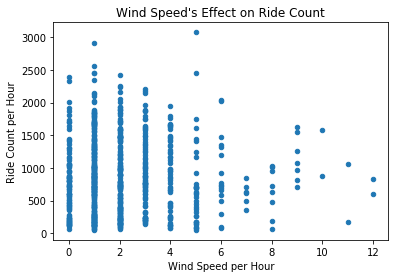

In [19]:
# Wind Speed and Ride Count 
df.plot.scatter('wind_speed','ride_count')
ax=plt.gca()
ax.set_title('Wind Speed\'s Effect on Ride Count')
ax.set_ylabel('Ride Count per Hour')
ax.set_xlabel('Wind Speed per Hour')

The scatter plot above shows some negative correlation. Since the data gathered on wind speed is strictly categorized as discrete numbers rather than non-discrete numbers such as decimals, each wind speed shows up as a discrete vertical stripe. However despite this, there is a clear "wedge" shape indicating that hours with higher ride counts are usually less windy. However, at higher wind speeds there is a gap of hours with lower ride counts, indicating that perhaps as the wind picks up more people ride uber instead of walking for fear of being blown over.

Text(0.5,0,'Humidity per Hour')

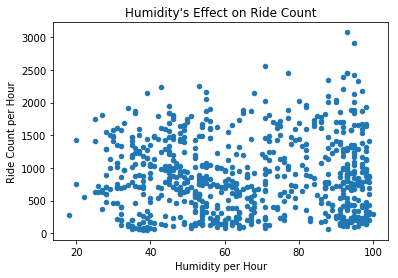

In [20]:
df.plot.scatter('humidity','ride_count')
ax=plt.gca()
ax.set_title('Humidity\'s Effect on Ride Count')
ax.set_ylabel('Ride Count per Hour')
ax.set_xlabel('Humidity per Hour')

The scatter plot above doesn't show much correlation. It is hard to tell the correlation from above since there is no clear trend of positive or negative correlation between these two variables. There may be some slight positive correlation given the upward slope of the maximum number of rides, but humidity itself does not seem to be a valuable predictor of uber traffic.

In [21]:
outcome, predictors = patsy.dmatrices('ride_count ~ temp_diff + humidity + wind_speed', df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             ride_count   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2.448
Date:                Wed, 12 Jun 2019   Prob (F-statistic):             0.0626
Time:                        12:18:14   Log-Likelihood:                -5756.5
No. Observations:                 742   AIC:                         1.152e+04
Df Residuals:                     738   BIC:                         1.154e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    968.4733     88.757     10.912      0.0

From the Regression Result, p-values for humidity and wind speed exceeds our alpha value of 0.01. This means that humidity and wind speed, when analyzed together, do not have a significant correlation with the ride counts.

In [22]:
outcome, predictors = patsy.dmatrices('ride_count ~ temp_diff', df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             ride_count   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     7.217
Date:                Wed, 12 Jun 2019   Prob (F-statistic):            0.00738
Time:                        12:18:14   Log-Likelihood:                -5756.6
No. Observations:                 742   AIC:                         1.152e+04
Df Residuals:                     740   BIC:                         1.153e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    947.8036     33.880     27.975      0.0

By rerunning the Regression result on the difference on temperature from mean temp, the p-value is significantly less than our alpha value. We can safely state that variation in temperature does have a statistically significant effect on the ride count.

In [23]:
outcome, predictors = patsy.dmatrices('ride_count ~ wind_speed', df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             ride_count   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.06268
Date:                Wed, 12 Jun 2019   Prob (F-statistic):              0.802
Time:                        12:18:14   Log-Likelihood:                -5760.1
No. Observations:                 742   AIC:                         1.152e+04
Df Residuals:                     740   BIC:                         1.153e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    881.7986     31.211     28.253      0.0

The p-value when ride count is regressed against wind speed is not less than our alpha of 0.01, and that the correlation between the two is not statistically significant.

In [24]:
df.iloc[229]
df.iloc[640]


datetime       2014-05-27 18:00:00
ride_count                    1197
description          broken clouds
temperature                     84
wind_speed                       6
humidity                        35
temp_diff                     22.2
Name: 642, dtype: object

Since it is hard to parametrize how a weather description can effect ride count, we decided it is ambiguious to use description to predict ride count. To see the actual effect of description, we included it in a Principal Component Analysis.

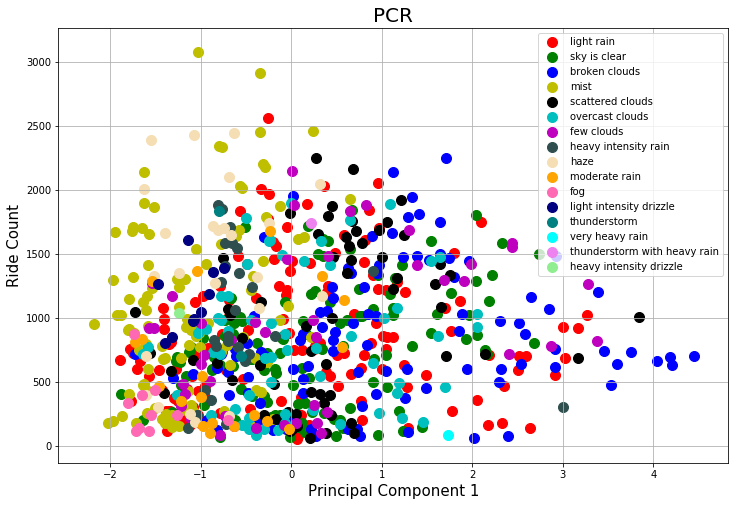

In [25]:
features = ['temperature', 'wind_speed', 'humidity']
# Separating out the features
x = df.loc[:, features].values
# Separating out the target
y = df.loc[:,['description']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal_component_1'])
finalDf = pd.concat([principalDf, df[['ride_count']], df[['description']]], axis = 1)
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Ride Count', fontsize = 15)
ax.set_title('PCR', fontsize = 20)
targets = ['light rain', 'sky is clear', 'broken clouds', 'mist', 'scattered clouds', 'overcast clouds', 'few clouds', 'heavy intensity rain','haze','moderate rain','fog','light intensity drizzle','thunderstorm','very heavy rain','thunderstorm with heavy rain','heavy intensity drizzle']
colors = ['r', 'g', 'b', 'y', 'k', 'c', 'm', 'darkslategrey', 'wheat','orange','hotpink','navy','teal','aqua','violet','lightgreen']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['description'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal_component_1'], finalDf.loc[indicesToKeep, 'ride_count'], c = color, s = 100)
ax.legend(targets)
ax.grid()

The PCA graph above shows that there may be some kind of negative correlation between the primary principal component of the weather data and the ride count. However, there is no clear practically significant correlation between the described weather conditions and the ride counts.

The scatterplot of PC1 against the ride count seems to resemble the graph of wind speed a lot, with a similar negative-sloping wedge and a gap along the lower right side. This may indicate that wind speed is weighted heavily in the PCA, perhaps indicating that it may have an outsized effect on ride count compared to our other metrics.

In [27]:
outcome, predictors = patsy.dmatrices('ride_count ~ principal_component_1', finalDf)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             ride_count   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     8.553
Date:                Wed, 12 Jun 2019   Prob (F-statistic):            0.00356
Time:                        12:18:27   Log-Likelihood:                -5739.2
No. Observations:                 740   AIC:                         1.148e+04
Df Residuals:                     738   BIC:                         1.149e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               873.96

A linear regression performed against PC1 returned a p-value of 0.00356, well below our alpha of 0.01. This indicates that the correlation between number of Uber rides taken per hour and the weather at large, represented by the primary principal component of all our weather data, is statistically significant and that on the whole, weather conditions do have a significant effect on ride density.

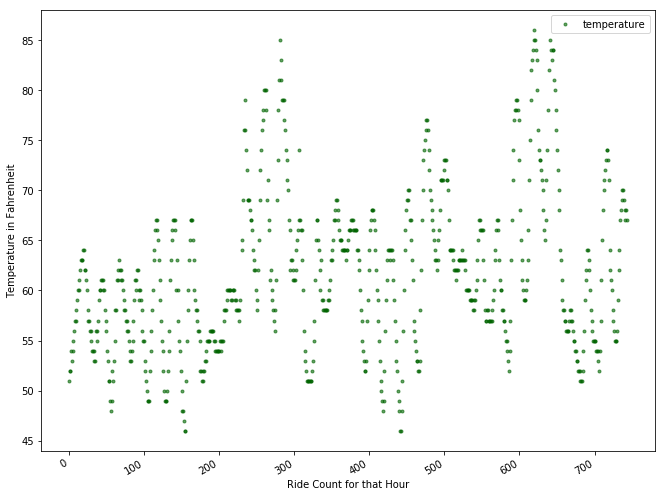

In [28]:
temperature_plot = ['temperature']
axes_temperature = df[temperature_plot].plot(marker='.', color="darkgreen",
                                                                 alpha=0.6, 
                                                                 linestyle='None', 
                                                                 figsize=(11, 9), 
                                                                 subplots=True)
for y_axis in axes_temperature:
    y_axis.set_ylabel('Temperature in Fahrenheit')
for x_axis in axes_temperature:
    x_axis.set_xlabel('Ride Count for that Hour')


In the graph above, Temperature does not seem to have a clear linear pattern with the ride count, suggesting that there is no predictive correlation between the temperature and the ride count. This suggests that temperature has no effect on the ride counts.

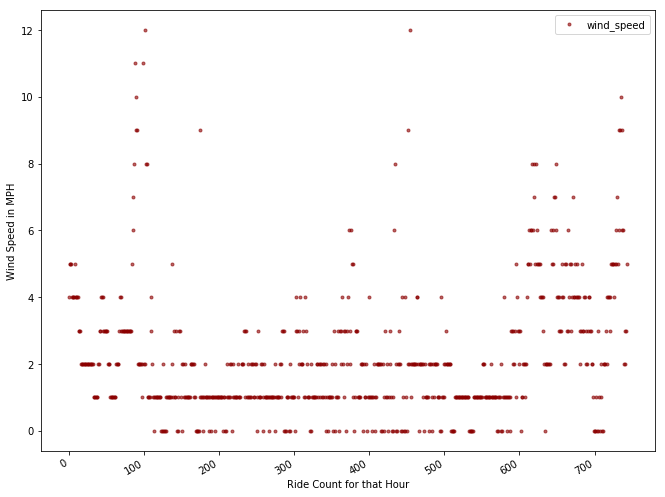

In [30]:
wind_speed_plot = ['wind_speed']
axes_wind_speed = df[wind_speed_plot].plot(marker='.', color="darkred",
                                                               alpha=0.6, 
                                                               linestyle='None', 
                                                               figsize=(11, 9), 
                                                               subplots=True)
for y_axis in axes_wind_speed:
    y_axis.set_ylabel('Wind Speed in MPH')
for x_axis in axes_wind_speed:
    x_axis.set_xlabel('Ride Count for that Hour')

In the graph above, the wind speed seems to show a little correlation that shows a horizontal
regression; the ride count is increasing despite the constant wind speeds in each of the rows. But this is not enough to show that there is a clear correlation between the wind speed and the ride count, suggesting that the wind speed has no effect on the ride counts.

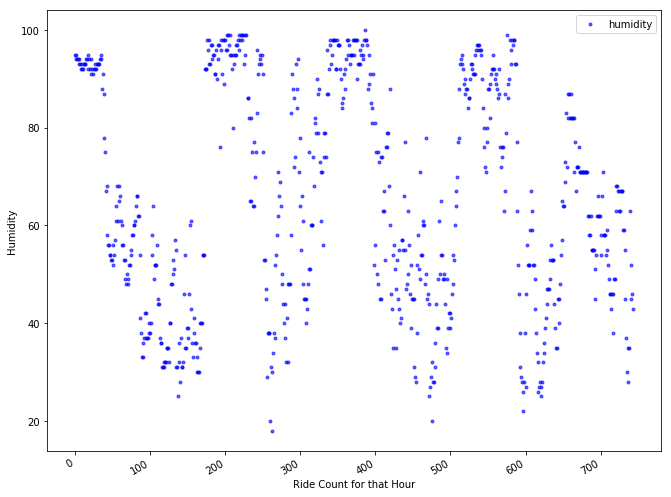

In [31]:
humidity_plot = ['humidity']
axes_humidity = df[humidity_plot].plot(marker='.', color="blue",
                                                           alpha=0.6, 
                                                           linestyle='None', 
                                                           figsize=(11, 9), 
                                                           subplots=True)
for y_axis in axes_humidity:
    y_axis.set_ylabel('Humidity')
    
for x_axis in axes_humidity:
    x_axis.set_xlabel('Ride Count for that Hour')
    

Although there is no linear pattern to this graph, we can see that there is a waveform pattern that shows a sine/cosine wave pattern. This shows that there is a significant correlation between humidity and ride count, suggesting that humidity does have an effect on the ride count.

# Ethics & Privacy

The data set we are analyzing for this project is public data obtained from an open source. The data on its own does not reveal any private information about individual users as well as Uber drivers so we are not as concerned with personal privacy. However, analyzers could still easily extract a lot of information from these data. For instance, analyzing this data set could reveal users’ commute patterns and preferences. Though this does not point to a specific person, it could be information that could be sold to other companies for profit. From this, companies can target users based on their individual preferences. For example, they could distribute advertisements based on these preferences. Or, rideshare apps, like Uber, could take advantage of all these data and deliberately raise prices when the demand is high. 

# Conclusion & Discussion

From our data analysis, humidity has a significant correlation to the ride count. It has an effect on the ride count more so than the other attributes we've analyzed. This could be because we tend to feel humidity relatively better without having to look at the weather forecast to see how humid the weather is for that day. Although temperature seems to have a significant correlation on some of our analysis, temperature during may 2014 in New York doesn't seem to have much effect on the ride count as much as we've expected in our hypothesis. This could be due to the fact that the weather is more stable during this time of the year, causing the temperature and the difference in temperature to not be significant enough to contribute to the ride count. Other factors such as wind speed and weather descriptions also did not show signficant correlation, and did not affect the ride count as much as humidity.